In [1]:
!conda install -c conda-forge folium=0.5.0
!pip install geocoder

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [2]:
!pip install beautifulsoup4
!pip install geopy

In [3]:
!pip install lxml

### Import required libraries

In [4]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

## Bengaluru Data

### Using BeautifulSoup to parse html file

In [5]:
url = 'https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Bangalore'
html_file = requests.get(url).text

In [6]:
soup = BeautifulSoup(html_file,'html5lib')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of neighbourhoods in Bangalore - Wikipedia
  </title>
  <script>
   document.documentElement.className=document.documentElement.className.replace(/(^|\s)client-nojs(\s|$)/,"$1client-js$2");RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_neighbourhoods_in_Bangalore","wgTitle":"List of neighbourhoods in Bangalore","wgCurRevisionId":896689983,"wgRevisionId":896689983,"wgArticleId":53117184,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Use dmy dates from August 2017","Use Indian English from August 2017","All Wikipedia articles written in Indian English","Neighbourhoods in Bangalore","Bangalore-related lists","Lists of neighbourhoods in Indian cities"],"wgBreakFrames":!1,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTa

### Reading required data

In [7]:
Region = []
for reg in soup.find_all('span',class_ = 'mw-headline'):
        Region.append(reg.text)
del Region[8:10]
print(Region)

['Central', 'Eastern', 'North-Eastern', 'Northern', 'South-Eastern', 'Southern', 'Southern suburbs', 'Western']


In [8]:
dfreg = []
dfarea = []
i = 0
for area1 in soup.find_all('table',class_='wikitable sortable'):
    for area2 in area1.find_all('td'):
        dfarea.append(area2.text.strip())
        dfreg.append(Region[i])
    i = i+1
dfreg = dfreg[::3]        
dfarea = dfarea[::3]
print(len(dfreg))
print(len(dfarea))

65
65


In [9]:
dflist = ['Region','Neighborhood']
df = pd.DataFrame(columns = dflist)
df['Region'] = dfreg
df['Neighborhood'] = dfarea
df

,Region,Neighborhood
0,Central,Cantonment area
1,Central,Domlur
2,Central,Indiranagar
3,Central,Jeevanbheemanagar
4,Central,Malleswaram
...,...,...
60,Western,Nandini Layout
61,Western,Nayandahalli
62,Western,Rajajinagar
63,Western,Rajarajeshwari Nagar


### Get Bengaluru Neighborhood coordinates

In [10]:
Head = ['Latitude', 'Longitude']
beng_csv = 'Bangalore_Coordinates.csv'
bengaluru_coord = pd.read_csv(beng_csv, names = Head)
bengaluru_coord.head()

,Latitude,Longitude
0,13.027925,77.533676
1,12.962467,77.638196
2,12.973291,77.640467
3,12.966008,77.657672
4,13.016341,77.558664


### Join Bengaluru Neighborhood data with their coordinates

In [11]:
dff = df.join(bengaluru_coord)
dff

,Region,Neighborhood,Latitude,Longitude
0,Central,Cantonment area,13.027925,77.533676
1,Central,Domlur,12.962467,77.638196
2,Central,Indiranagar,12.973291,77.640467
3,Central,Jeevanbheemanagar,12.966008,77.657672
4,Central,Malleswaram,13.016341,77.558664
...,...,...,...,...
60,Western,Nandini Layout,13.010406,77.537803
61,Western,Nayandahalli,12.944600,77.525600
62,Western,Rajajinagar,12.988234,77.554883
63,Western,Rajarajeshwari Nagar,12.927428,77.515372


### Get coordinates of Bengaluru

In [12]:
address = 'Bengaluru, Karnataka'

geolocator = Nominatim(user_agent="Beng")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bengaluru are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bengaluru are 12.9791198, 77.5912997.


### Visualize map of Bengaluru with Neighborhood markers

In [13]:
import folium
# create map of Bengaluru using latitude and longitude values
map_bengaluru = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(dff['Latitude'], dff['Longitude'], dff['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bengaluru)  
    
map_bengaluru

### Foursquare API Credentials

In [14]:
CLIENT_ID = 'OREU0ESXHHUMVDEFEGAJAEVFTCQRUR2EZJWZYLBUM1A5YCUY' # your Foursquare ID
CLIENT_SECRET = '1PDNS3NFJ4UCMMFUXHADFBEST54XSFWZWT4P1QJSJ55XPRER' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OREU0ESXHHUMVDEFEGAJAEVFTCQRUR2EZJWZYLBUM1A5YCUY
CLIENT_SECRET:1PDNS3NFJ4UCMMFUXHADFBEST54XSFWZWT4P1QJSJ55XPRER


### Defining function to obtain nearby venues

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Getting nearby venues in Bengaluru

In [16]:
bengaluru_venues = getNearbyVenues(names=dff['Neighborhood'],
                                   latitudes=dff['Latitude'],
                                   longitudes=dff['Longitude']
                                  )

Cantonment area
Domlur
Indiranagar
Jeevanbheemanagar
Malleswaram
Pete area
Sadashivanagar
Seshadripuram
Shivajinagar
Ulsoor
Vasanth Nagar
Bellandur
CV Raman Nagar
Hoodi
Krishnarajapuram
Mahadevapura
Marathahalli
Varthur
Whitefield
Banaswadi
HBR Layout
Horamavu
Kalyan Nagar
Kammanahalli
Lingarajapuram
Ramamurthy Nagar
Hebbal
Jalahalli
Mathikere
Peenya
R. T. Nagar
Vidyaranyapura
Yelahanka
Yeshwanthpur
Bommanahalli
Bommasandra
BTM Layout
Electronic City
HSR Layout
Koramangala
Madiwala
Banashankari
Basavanagudi
Girinagar
J. P. Nagar
Jayanagar
Kumaraswamy Layout
Padmanabhanagar
Uttarahalli
Anjanapura
Arekere
Begur
Gottigere
Hulimavu
Kothnur
Basaveshwaranagar
Kamakshipalya
Kengeri
Mahalakshmi Layout
Nagarbhavi
Nandini Layout
Nayandahalli
Rajajinagar
Rajarajeshwari Nagar
Vijayanagar


### Let us remove venue categories containing 'Neighborhood'

In [17]:
bengaluru_venues = bengaluru_venues[bengaluru_venues['Venue Category'] != 'Neighborhood']
print(bengaluru_venues.shape)

(2807, 7)


### Display number of Unique Categories

In [18]:
print('There are {} uniques categories.'.format(len(bengaluru_venues['Venue Category'].unique())))

There are 210 uniques categories.


### Display count of Unique Categories in each Neighborhood

In [19]:
bengaluru_venues.groupby('Neighborhood')['Venue Category'].nunique().to_frame().sort_values('Venue Category', ascending = False)

,Venue Category
Neighborhood,
Indiranagar,51
Domlur,48
Shivajinagar,47
Seshadripuram,47
Koramangala,46
...,...
Anjanapura,7
Horamavu,6
Kamakshipalya,6


### Display count of each Venue Category in each Neighborhood

In [20]:
vencount = bengaluru_venues.groupby('Neighborhood')['Venue Category'].value_counts().to_frame()
vencount.columns = ['Venue Count']
vencount.sort_values('Venue Count', ascending = False)
vencount

Venue Count
Neighborhood Venue Category                 
Anjanapura   ATM                           1
             Asian Restaurant              1
             Campground                    1
             Flower Shop                   1
             Photography Lab               1
...                                      ...
Yeshwanthpur Park                          1
             Seafood Restaurant            1
             Shopping Mall                 1
             Spa                           1
             Wine Bar                      1

[1589 rows x 1 columns]

## Delhi Data

### Load Delhi Neighborhood Data

In [21]:
delhi_head = ['Region','Neighborhood']
delhi_data = pd.read_csv('Delhi_Neighbourhoods.csv', names = delhi_head)
delhi_data.head()

,Region,Neighborhood
0,North West Delhi,Adarsh Nagar
1,North West Delhi,Ashok Vihar
2,North West Delhi,Azadpur
3,North West Delhi,Bawana
4,North West Delhi,Begum Pur


In [22]:
delhi_coord = pd.read_csv('Delhi_Coord.csv', names = Head)
delhi_coord.head()

,Latitude,Longitude
0,28.614193,77.071541
1,28.698510,77.185030
2,28.707657,77.175547
3,28.799660,77.032885
4,28.722400,77.066150


In [23]:
delhi_data = delhi_data.join(delhi_coord)

In [24]:
delhi_data.shape

(185, 4)

In [25]:
delhi_data['Neighborhood'].nunique()

175

### Remove redundant rows

In [26]:
delhi_data.drop_duplicates(subset ="Neighborhood", 
                     keep = 'first', inplace = True)
delhi_data.reset_index(drop = True, inplace = True)
delhi_data

,Region,Neighborhood,Latitude,Longitude
0,North West Delhi,Adarsh Nagar,28.614193,77.071541
1,North West Delhi,Ashok Vihar,28.698510,77.185030
2,North West Delhi,Azadpur,28.707657,77.175547
3,North West Delhi,Bawana,28.799660,77.032885
4,North West Delhi,Begum Pur,28.722400,77.066150
...,...,...,...,...
170,West Delhi,Tihar Village,28.634636,77.107112
171,West Delhi,Tilak Nagar,28.639650,77.094039
172,West Delhi,Uttam Nagar,28.629860,77.053080
173,West Delhi,Vikas Nagar,28.644009,77.054470


### Get coordinates of Delhi

In [27]:
address_delhi = 'Delhi, India'

geolocator = Nominatim(user_agent="del")
location_delhi = geolocator.geocode(address_delhi)
latitude_delhi = location_delhi.latitude
longitude_delhi = location_delhi.longitude
print('The geograpical coordinates of Delhi are {}, {}.'.format(latitude_delhi, longitude_delhi))

The geograpical coordinates of Delhi are 28.6517178, 77.2219388.


### Visualize map of Delhi with Neighborhood markers

In [28]:
# create map of Delhi using latitude and longitude values
map_delhi = folium.Map(location=[latitude_delhi, longitude_delhi], zoom_start=11)

# add markers to map
for lat, lng, label2 in zip(delhi_data['Latitude'], delhi_data['Longitude'], delhi_data['Neighborhood']):
    label2 = folium.Popup(label2, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label2,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

### Getting nearby venues in Delhi

In [29]:
delhi_venues = getNearbyVenues(names=delhi_data['Neighborhood'],
                                   latitudes=delhi_data['Latitude'],
                                   longitudes=delhi_data['Longitude']
                                  )

Adarsh Nagar
Ashok Vihar
Azadpur
Bawana
Begum Pur
Dhaka
Jahangirpuri
Karala
Keshav Puram
Kingsway Camp
Kohat Enclave
Model Town
Narela
Pitam Pura
Rani Bagh
Rithala
Rohini Sub City
Shalimar Bagh
Shakti Nagar
Bara Hindu Rao
Chandni Chowk
Chawri Bazaar
Civil Lines
Dariba Kalan
Ghantewala
Gulabi Bagh
Kamla Nagar
Kashmiri Gate
Kotwali
Lahori Gate
Nehru Vihar
Paharganj
Pratap Nagar
Pul Bangash
Roshanara Bagh
Sadar Bazaar
Sangam Vihar
Sant Nagar
Sarai Kale Khan
Sarai Rohilla
Shastri Nagar
Tees Hazari
Timarpur
Wazirabad
Babarpur
Dilshad Garden
Kabir Nagar
Mandoli
Maujpur
Nand Nagri
Naveen Shahdara
New Usmanpur
Sadatpur
Shahdara
Sonia Vihar
Shastri Park
Yamuna Vihar
Daryaganj
Jhandewalan
Karol Bagh
Rajender Nagar
Barakhamba Road
Chanakyapuri
Connaught Place
Gautampuri
Gole Market
Golf Links
INA Colony
Khan Market
Laxmibai Nagar
Pragati Maidan
Brij Puri
East Vinod Nagar
Gandhi Nagar
Geeta Colony
Jhilmil Colony
Krishna Nagar
Laxmi Nagar
Mayur Vihar
Pandav Nagar
Patparganj
Preet Vihar
Anand Vihar


### Let us remove venue categories containing 'Neighborhood'

In [30]:
delhi_venues = delhi_venues[delhi_venues['Venue Category'] != 'Neighborhood']
print(delhi_venues.shape)

(5894, 7)


### Display number of Unique Categories

In [31]:
print('There are {} uniques categories.'.format(len(delhi_venues['Venue Category'].unique())))

There are 226 uniques categories.


### Display count of Unique Categories in each Neighborhood

In [32]:
delhi_venues.groupby('Neighborhood')['Venue Category'].nunique().to_frame().sort_values('Venue Category', ascending = False)

,Venue Category
Neighborhood,
Lodi Colony,54
Khan Market,53
Golf Links,53
Pulpehaladpur,49
Pul Bangash,49
...,...
Najafgarh,2
New Usmanpur,2
Jamroodpur Village,1


### Display count of each Venue Category in each Neighborhood

In [33]:
vencount2 = delhi_venues.groupby('Neighborhood')['Venue Category'].value_counts().to_frame()
vencount2.columns = ['Venue Count']
vencount2.sort_values('Venue Count', ascending = False)
vencount2

Venue Count
Neighborhood Venue Category                         
Adarsh Nagar Indian Restaurant                     3
             Bus Station                           1
             Light Rail Station                    1
             Pool                                  1
Alaknanda    Indian Restaurant                     6
...                                              ...
Yamuna Vihar Botanical Garden                      1
             Electronics Store                     1
             Mobile Phone Shop                     1
             Pizza Place                           1
             Tourist Information Center            1

[3375 rows x 1 columns]

## Join Delhi and Bengaluru Data

In [34]:
del_ban_data = bengaluru_venues.append(delhi_venues, ignore_index = True) 
del_ban_data

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cantonment area,13.027925,77.533676,Vivanta by Taj - Yeshwantpur,13.029152,77.540565,Hotel
1,Cantonment area,13.027925,77.533676,Uppu Munchi,13.027989,77.541080,Seafood Restaurant
2,Cantonment area,13.027925,77.533676,"Palette, Taj Vivanta",13.029171,77.540681,Restaurant
3,Cantonment area,13.027925,77.533676,Azure,13.029278,77.540712,Mediterranean Restaurant
4,Cantonment area,13.027925,77.533676,Cafe Coffee Day,13.033800,77.531082,Coffee Shop
...,...,...,...,...,...,...,...
8696,Vikaspuri,28.638419,77.070836,Hilton Executive Lounge,28.628905,77.078872,Hotel
8697,Vikaspuri,28.638419,77.070836,KFC,28.629583,77.082092,Fast Food Restaurant
8698,Vikaspuri,28.638419,77.070836,Yo! China,28.630361,77.081553,Chinese Restaurant
8699,Vikaspuri,28.638419,77.070836,Musicland,28.630172,77.082216,Music Store


### One hot encoding

In [35]:
# one hot encoding
del_ban_onehot = pd.get_dummies(del_ban_data[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
del_ban_onehot['Neighborhood'] = del_ban_data['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [del_ban_onehot.columns[-1]] + list(del_ban_onehot.columns[:-1])
del_ban_onehot = del_ban_onehot[fixed_columns]

del_ban_onehot.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,American Restaurant,Andhra Restaurant,Antique Shop,...,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Cantonment area,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Count of Venue Category in each Neighborhood

In [36]:
count_data = del_ban_onehot.groupby(['Neighborhood']).sum().reset_index()
count_data.head()

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,American Restaurant,Andhra Restaurant,Antique Shop,...,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alaknanda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Anand Vihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Anjanapura,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Arekere,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Grouping Data based on Neighborhood

In [37]:
del_ban_grouped = del_ban_onehot.groupby('Neighborhood').mean().reset_index()
del_ban_grouped

,Neighborhood,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,American Restaurant,Andhra Restaurant,Antique Shop,...,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,Adarsh Nagar,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
1,Alaknanda,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
2,Anand Vihar,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
3,Anjanapura,0.142857,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
4,Arekere,0.000000,0.0,0.0,0.0,0.0,0.0,0.019608,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,Wazirabad,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
235,Whitefield,0.000000,0.0,0.0,0.0,0.0,0.0,0.021277,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
236,Yamuna Vihar,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0
237,Yelahanka,0.000000,0.0,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,...,0.0,0.0,0.055556,0.0,0.0,0.00000,0.0,0.0,0.0,0.0


## Clustering Data using K-Means

In [38]:
del_ban_clustering = del_ban_grouped.drop('Neighborhood', 1)
del_ban_clustering.head()

,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,American Restaurant,Andhra Restaurant,Antique Shop,Arcade,...,Udupi Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.142857,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.019608,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Finding optimal 'K'

In [39]:
distortions = []
K = range(1,9)
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=0).fit(del_ban_clustering)
    distortions.append(kmeanModel.inertia_)

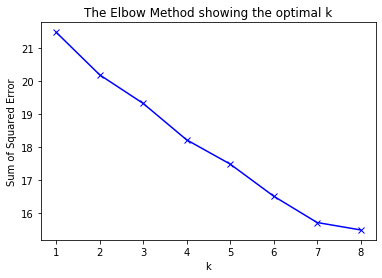

In [40]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of Squared Error')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [41]:

for n in range(2,9):
    kmeans = KMeans(n_clusters=n).fit(del_ban_clustering)
    label = kmeans.labels_
    sil_coeff = silhouette_score(del_ban_clustering, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.24830621831876404
For n_clusters=3, The Silhouette Coefficient is 0.22738089912935813
For n_clusters=4, The Silhouette Coefficient is 0.04815651822159422
For n_clusters=5, The Silhouette Coefficient is 0.4439729699184991
For n_clusters=6, The Silhouette Coefficient is 0.06522197153620687
For n_clusters=7, The Silhouette Coefficient is 0.056548047934685236
For n_clusters=8, The Silhouette Coefficient is 0.0750110720117935


### Apply K-Means for K=7

In [42]:
# set number of clusters
cluster_num = 7
# run k-means clustering
kmeans_cluster = KMeans(n_clusters=cluster_num).fit(del_ban_clustering)
# check cluster labels
kmeans_cluster.labels_[0:10]

array([1, 6, 0, 6, 6, 6, 6, 6, 1, 4], dtype=int32)

### Display top 10 Venues of Each Neighborhood with their Cluster Labels

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = del_ban_grouped['Neighborhood']

for ind in np.arange(del_ban_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(del_ban_grouped.iloc[ind, :], num_top_venues)
neighborhoods_venues_sorted.insert(1, 'Cluster Label', kmeans_cluster.labels_)
neighborhoods_venues_sorted.head()

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,1,Indian Restaurant,Bus Station,Light Rail Station,Pool,Dance Studio,Falafel Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop
1,Alaknanda,6,Indian Restaurant,Market,Pizza Place,Coffee Shop,Restaurant,BBQ Joint,Asian Restaurant,Café,Sandwich Place,Fast Food Restaurant
2,Anand Vihar,0,Pizza Place,Multiplex,Hotel,Shopping Mall,Café,Indian Restaurant,Athletics & Sports,Food Truck,Movie Theater,Metro Station
3,Anjanapura,6,ATM,Campground,Pool,Photography Lab,Snack Place,Flower Shop,Asian Restaurant,Field,Farm,Farmers Market
4,Arekere,6,Indian Restaurant,Department Store,Movie Theater,Multiplex,Sporting Goods Shop,Café,Pizza Place,Bakery,Cosmetics Shop,Electronics Store


### Add City and Region to each Neighborhood

In [45]:
banreg = dff[['Region','Neighborhood']]
banreg.insert(0,'City','Bengaluru')
delreg = delhi_data[['Region','Neighborhood']]
delreg.insert(0,'City','Delhi')
reg_data = banreg.append(delreg)
reg_data

,City,Region,Neighborhood
0,Bengaluru,Central,Cantonment area
1,Bengaluru,Central,Domlur
2,Bengaluru,Central,Indiranagar
3,Bengaluru,Central,Jeevanbheemanagar
4,Bengaluru,Central,Malleswaram
...,...,...,...
170,Delhi,West Delhi,Tihar Village
171,Delhi,West Delhi,Tilak Nagar
172,Delhi,West Delhi,Uttam Nagar
173,Delhi,West Delhi,Vikas Nagar


In [46]:
neighborhood = neighborhoods_venues_sorted.set_index('Neighborhood').join(reg_data.set_index('Neighborhood')).reset_index()
neighborhood.head()

,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,City,Region
0,Adarsh Nagar,1,Indian Restaurant,Bus Station,Light Rail Station,Pool,Dance Studio,Falafel Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop,Delhi,North West Delhi
1,Alaknanda,6,Indian Restaurant,Market,Pizza Place,Coffee Shop,Restaurant,BBQ Joint,Asian Restaurant,Café,Sandwich Place,Fast Food Restaurant,Delhi,South Delhi
2,Anand Vihar,0,Pizza Place,Multiplex,Hotel,Shopping Mall,Café,Indian Restaurant,Athletics & Sports,Food Truck,Movie Theater,Metro Station,Delhi,East Delhi
3,Anjanapura,6,ATM,Campground,Pool,Photography Lab,Snack Place,Flower Shop,Asian Restaurant,Field,Farm,Farmers Market,Bengaluru,Southern suburbs
4,Arekere,6,Indian Restaurant,Department Store,Movie Theater,Multiplex,Sporting Goods Shop,Café,Pizza Place,Bakery,Cosmetics Shop,Electronics Store,Bengaluru,Southern suburbs


### Move Columns 'Neighborhood and 'City' to first position

In [47]:
cols = neighborhood.columns.tolist()
cols = cols[-2:] + cols[:-2]
neighborhood = neighborhood[cols]
neighborhood.head()

,City,Region,Neighborhood,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Delhi,North West Delhi,Adarsh Nagar,1,Indian Restaurant,Bus Station,Light Rail Station,Pool,Dance Studio,Falafel Restaurant,French Restaurant,Food Truck,Food Court,Food & Drink Shop
1,Delhi,South Delhi,Alaknanda,6,Indian Restaurant,Market,Pizza Place,Coffee Shop,Restaurant,BBQ Joint,Asian Restaurant,Café,Sandwich Place,Fast Food Restaurant
2,Delhi,East Delhi,Anand Vihar,0,Pizza Place,Multiplex,Hotel,Shopping Mall,Café,Indian Restaurant,Athletics & Sports,Food Truck,Movie Theater,Metro Station
3,Bengaluru,Southern suburbs,Anjanapura,6,ATM,Campground,Pool,Photography Lab,Snack Place,Flower Shop,Asian Restaurant,Field,Farm,Farmers Market
4,Bengaluru,Southern suburbs,Arekere,6,Indian Restaurant,Department Store,Movie Theater,Multiplex,Sporting Goods Shop,Café,Pizza Place,Bakery,Cosmetics Shop,Electronics Store


## Group 1

In [48]:
group1_common = neighborhood.loc[neighborhood['Cluster Label'] == 0, neighborhood.columns[list(range(0, neighborhood.shape[1]))]]
group1 = group1_common[['City','Region','Neighborhood']].reset_index(drop=True)
group1.sort_values('City').reset_index(drop = True)

,City,Region,Neighborhood
0,Bengaluru,Northern,Yelahanka
1,Bengaluru,North-Eastern,HBR Layout
2,Bengaluru,South-Eastern,HSR Layout
3,Bengaluru,Northern,Hebbal
4,Bengaluru,Western,Kamakshipalya
5,Bengaluru,Western,Kengeri
6,Bengaluru,Eastern,Whitefield
7,Bengaluru,Western,Nandini Layout
8,Bengaluru,Western,Rajarajeshwari Nagar
9,Delhi,East Delhi,Vishwas Nagar


### Average Count of Venue Category

In [49]:
Cat_col = ['Category','Count']
group1_venues = group1.set_index('Neighborhood').join(count_data.set_index('Neighborhood')).reset_index()
group1_venues = group1_venues.mean().to_frame().reset_index()
group1_venues.columns = Cat_col
group1_venues = group1_venues.sort_values('Count', ascending = False)
group1_venues = group1_venues[group1_venues['Count'] != 0].reset_index(drop = True)
group1_venues

,Category,Count
0,Café,2.76
1,Pizza Place,1.92
2,Indian Restaurant,1.76
3,Hotel,1.24
4,Fast Food Restaurant,0.56
...,...,...
101,Yoga Studio,0.04
102,Andhra Restaurant,0.04
103,Boat or Ferry,0.04
104,Temple,0.04


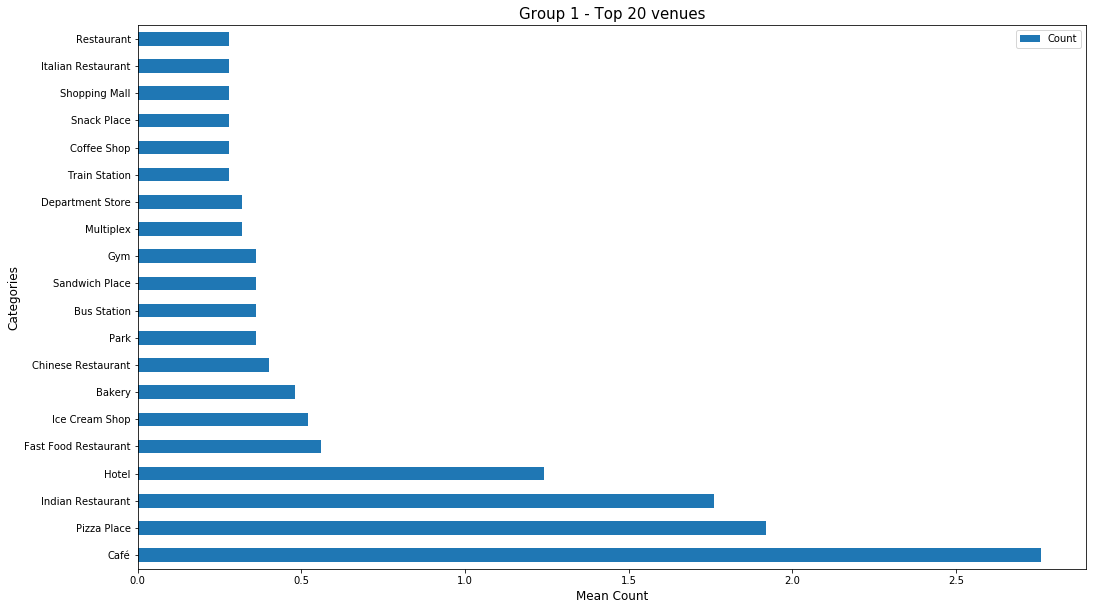

In [50]:
group1_venues.set_index('Category').head(20).plot(kind='barh', figsize=(17, 10))

plt.xlabel('Mean Count',size=12) 
plt.ylabel('Categories',size=12)
plt.title('Group 1 - Top 20 venues',size=15) 

plt.show()

## Group 2

In [51]:
group2_common = neighborhood.loc[neighborhood['Cluster Label'] == 1, neighborhood.columns[list(range(0, neighborhood.shape[1]))]]
group2 = group2_common[['City','Region','Neighborhood']].reset_index(drop=True)
group2.sort_values('City').reset_index(drop = True)

,City,Region,Neighborhood
0,Bengaluru,North-Eastern,Ramamurthy Nagar
1,Bengaluru,North-Eastern,Kammanahalli
2,Bengaluru,Northern,R. T. Nagar
3,Bengaluru,Central,Jeevanbheemanagar
4,Bengaluru,Southern,Jayanagar
...,...,...,...
71,Delhi,New Delhi,Laxmibai Nagar
72,Delhi,South West Delhi,Mahipalpur
73,Delhi,West Delhi,Meera Bagh
74,Delhi,North East Delhi,New Usmanpur


### Average Count of Venue Category

In [52]:
group2_venues = group2.set_index('Neighborhood').join(count_data.set_index('Neighborhood')).reset_index()
group2_venues = group2_venues.mean().to_frame().reset_index()
group2_venues.columns = Cat_col
group2_venues = group2_venues.sort_values('Count', ascending = False)
group2_venues = group2_venues[group2_venues['Count'] != 0].reset_index(drop = True)
group2_venues

,Category,Count
0,Indian Restaurant,7.605263
1,Hotel,2.697368
2,Café,2.118421
3,Fast Food Restaurant,1.592105
4,Coffee Shop,1.315789
...,...,...
201,Flower Shop,0.013158
202,Farm,0.013158
203,Field,0.013158
204,Toy / Game Store,0.013158


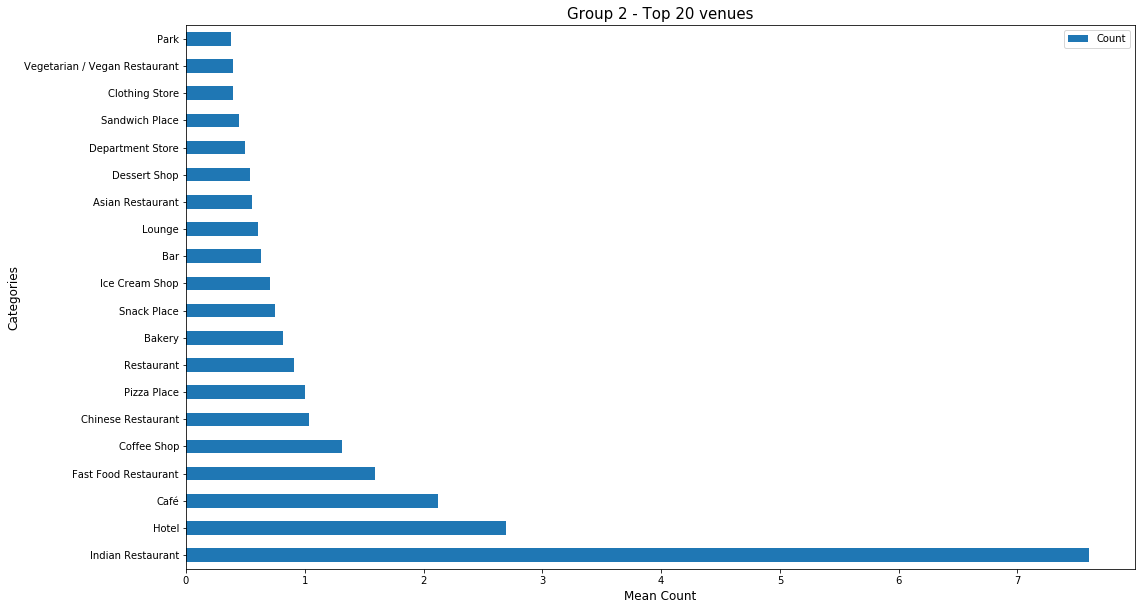

In [53]:
group2_venues.set_index('Category').head(20).plot(kind='barh', figsize=(17, 10))

plt.xlabel('Mean Count',size=12) 
plt.ylabel('Categories',size=12)
plt.title('Group 2 - Top 20 venues',size=15) 

plt.show()

## Group 3

In [54]:
group3_common = neighborhood.loc[neighborhood['Cluster Label'] == 2, neighborhood.columns[list(range(0, neighborhood.shape[1]))]]
group3 = group3_common[['City','Region','Neighborhood']].reset_index(drop=True)
group3.sort_values('City').reset_index(drop = True)

,City,Region,Neighborhood
0,Delhi,South Delhi,Jaitpur
1,Delhi,North West Delhi,Karala
2,Delhi,North West Delhi,Narela
3,Delhi,North Delhi,Sangam Vihar


### Average Count of Venue Category

In [55]:
group3_venues = group3.set_index('Neighborhood').join(count_data.set_index('Neighborhood')).reset_index()
group3_venues = group3_venues.mean().to_frame().reset_index()
group3_venues.columns = Cat_col
group3_venues = group3_venues.sort_values('Count', ascending = False)
group3_venues = group3_venues[group3_venues['Count'] != 0].reset_index(drop = True)
group3_venues

,Category,Count
0,ATM,1.25
1,Electronics Store,0.50
2,Furniture / Home Store,0.25
3,Tea Room,0.25
4,Chinese Restaurant,0.25
5,Trail,0.25
6,Clothing Store,0.25
7,Men's Store,0.25


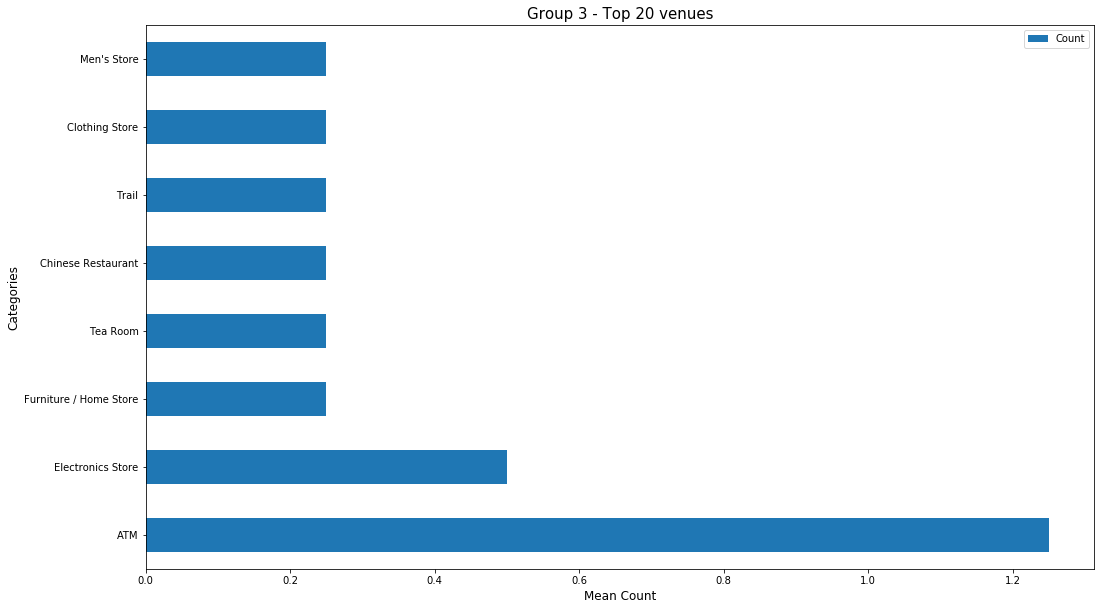

In [56]:
group3_venues.set_index('Category').head(20).plot(kind='barh', figsize=(17, 10))

plt.xlabel('Mean Count',size=12) 
plt.ylabel('Categories',size=12)
plt.title('Group 3 - Top 20 venues',size=15) 

plt.show()

## Group 4

In [57]:
group4_common = neighborhood.loc[neighborhood['Cluster Label'] == 3, neighborhood.columns[list(range(0, neighborhood.shape[1]))]]
group4 = group4_common[['City','Region','Neighborhood']].reset_index(drop=True)
group4.sort_values('City').reset_index(drop = True)

,City,Region,Neighborhood
0,Delhi,South Delhi,Jamroodpur Village


### Average Count of Venue Category

In [58]:
group4_venues= group4.set_index('Neighborhood').join(count_data.set_index('Neighborhood')).reset_index()
group4_venues = group4_venues.mean().to_frame().reset_index()
group4_venues.columns = Cat_col
group4_venues = group4_venues.sort_values('Count', ascending = False)
group4_venues = group4_venues[group4_venues['Count'] != 0].reset_index(drop = True)
group4_venues

,Category,Count
0,Restaurant,1.0


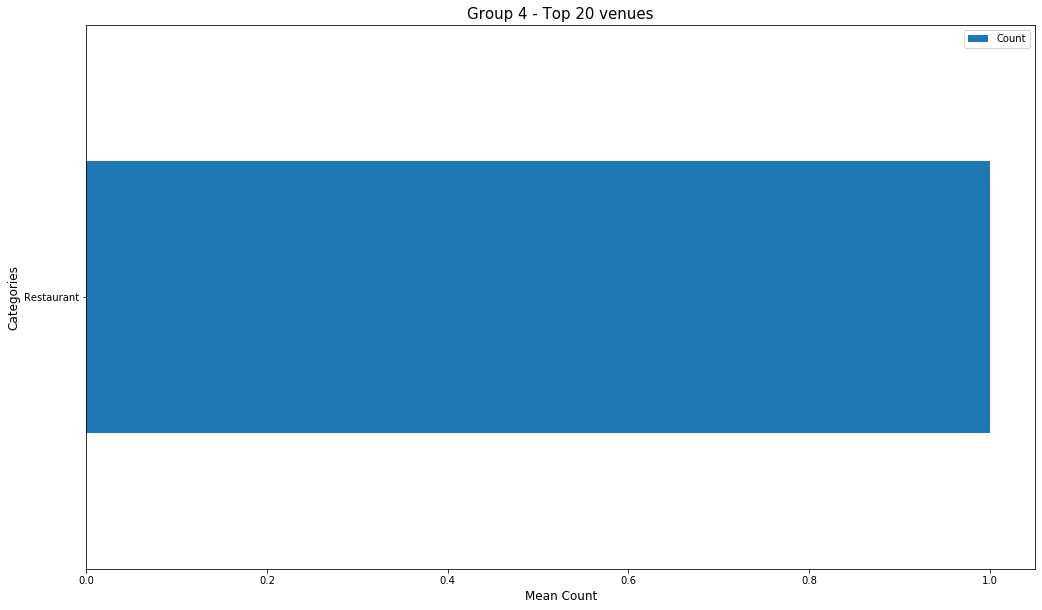

In [59]:
group4_venues.set_index('Category').head(20).plot(kind='barh', figsize=(17, 10))

plt.xlabel('Mean Count',size=12) 
plt.ylabel('Categories',size=12)
plt.title('Group 4 - Top 20 venues',size=15) 

plt.show()

## Group 5

In [60]:
group5_common = neighborhood.loc[neighborhood['Cluster Label'] == 4, neighborhood.columns[list(range(0, neighborhood.shape[1]))]]
group5 = group5_common[['City','Region','Neighborhood']].reset_index(drop=True)
group5.sort_values('City').reset_index(drop = True)

,City,Region,Neighborhood
0,Bengaluru,Southern suburbs,Begur
1,Bengaluru,North-Eastern,Horamavu
2,Delhi,North East Delhi,Babarpur
3,Delhi,North Delhi,Tees Hazari
4,Delhi,East Delhi,Silampur
5,Delhi,North Delhi,Shastri Nagar
6,Delhi,North Delhi,Sarai Rohilla
7,Delhi,North West Delhi,Rani Bagh
8,Delhi,West Delhi,Patel Nagar
9,Delhi,North East Delhi,Naveen Shahdara


### Average Count of Venue Category

In [61]:
group5_venues = group5.set_index('Neighborhood').join(count_data.set_index('Neighborhood')).reset_index()
group5_venues = group5_venues.mean().to_frame().reset_index()
group5_venues.columns = Cat_col
group5_venues = group5_venues.sort_values('Count', ascending = False)
group5_venues = group5_venues[group5_venues['Count'] != 0].reset_index(drop = True)
group5_venues

,Category,Count
0,Pizza Place,1.217391
1,Park,0.608696
2,Train Station,0.565217
3,Indian Restaurant,0.434783
4,Snack Place,0.391304
5,Dessert Shop,0.391304
6,Light Rail Station,0.260870
7,Department Store,0.260870
8,Coffee Shop,0.217391
9,Ice Cream Shop,0.217391


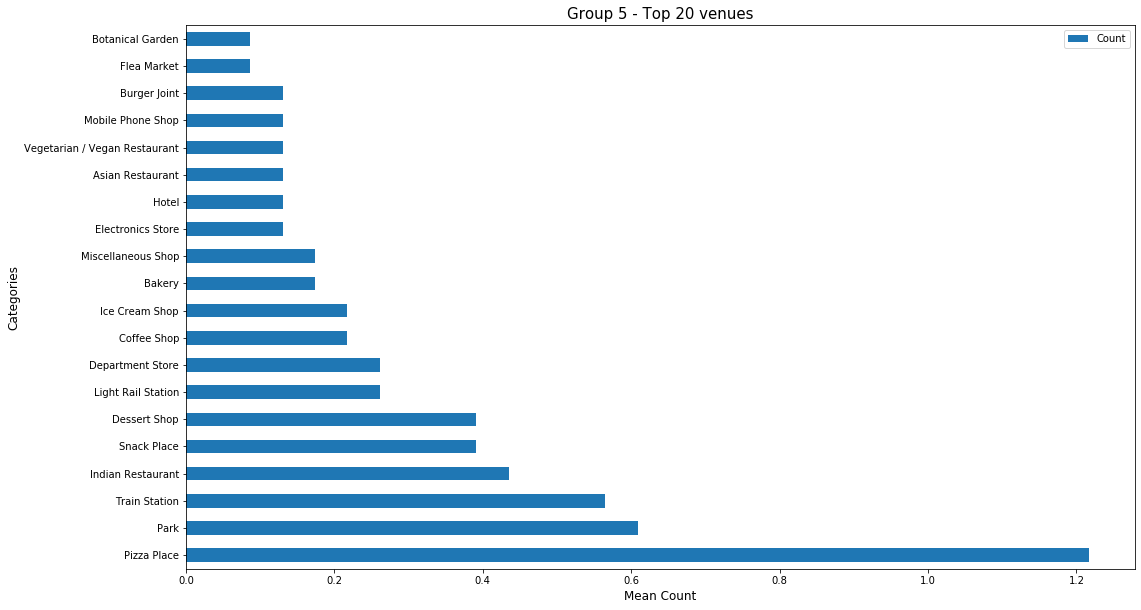

In [62]:
group5_venues.set_index('Category').head(20).plot(kind='barh', figsize=(17, 10))

plt.xlabel('Mean Count',size=12) 
plt.ylabel('Categories',size=12)
plt.title('Group 5 - Top 20 venues',size=15) 

plt.show()

## Group 6

In [63]:
group6_common = neighborhood.loc[neighborhood['Cluster Label'] == 5, neighborhood.columns[list(range(0, neighborhood.shape[1]))]]
group6 = group6_common[['City','Region','Neighborhood']].reset_index(drop=True)
group6.sort_values('City').reset_index(drop = True)

,City,Region,Neighborhood
0,Delhi,South West Delhi,Sagar Pur


### Average Count of Venue Category

In [64]:
group6_venues = group6.set_index('Neighborhood').join(count_data.set_index('Neighborhood')).reset_index()
group6_venues = group6_venues.mean().to_frame().reset_index()
group6_venues.columns = Cat_col
group6_venues = group6_venues.sort_values('Count', ascending = False)
group6_venues = group6_venues[group6_venues['Count'] != 0].reset_index(drop = True)
group6_venues

,Category,Count
0,Tourist Information Center,1.0


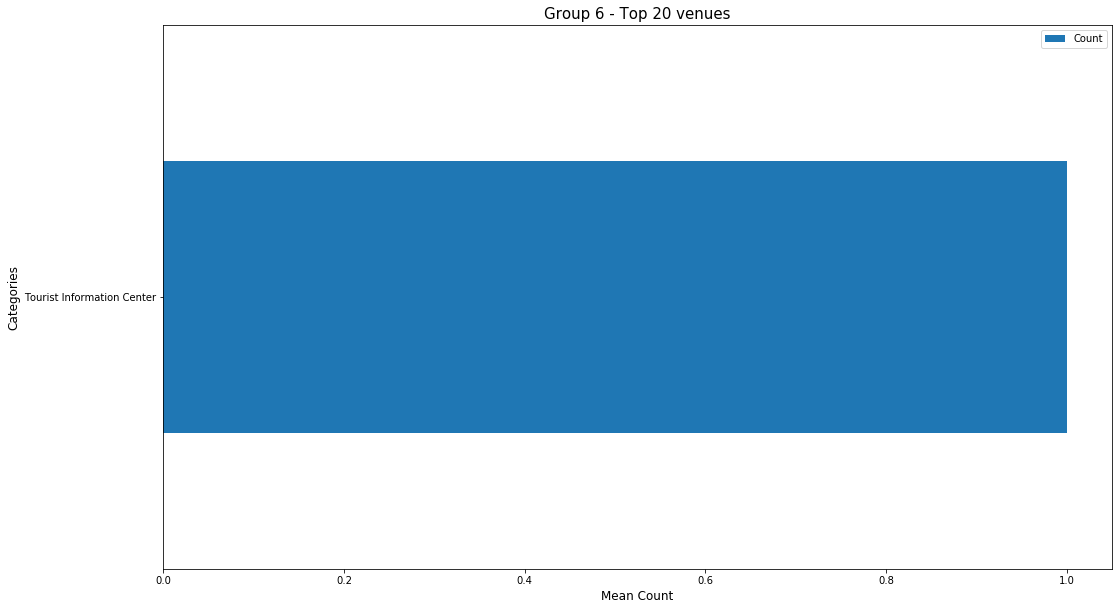

In [65]:
group6_venues.set_index('Category').head(20).plot(kind='barh', figsize=(17, 10))

plt.xlabel('Mean Count',size=12) 
plt.ylabel('Categories',size=12)
plt.title('Group 6 - Top 20 venues',size=15) 

plt.show()

## Group 7

In [66]:
group7_common = neighborhood.loc[neighborhood['Cluster Label'] == 6, neighborhood.columns[list(range(0, neighborhood.shape[1]))]]
group7 = group7_common[['City','Region','Neighborhood']].reset_index(drop=True)
group7.sort_values('City').reset_index(drop = True)

,City,Region,Neighborhood
0,Bengaluru,Northern,Yeshwanthpur
1,Bengaluru,Central,Indiranagar
2,Bengaluru,North-Eastern,Kalyan Nagar
3,Bengaluru,Southern suburbs,Hulimavu
4,Bengaluru,Eastern,Hoodi
...,...,...,...
104,Delhi,East Delhi,Jhilmil Colony
105,Delhi,South Delhi,Jangpura
106,Delhi,North West Delhi,Jahangirpuri
107,Delhi,South Delhi,Khirki Village


### Average Count of Venue Category

In [67]:
group7_venues = group7.set_index('Neighborhood').join(count_data.set_index('Neighborhood')).reset_index()
group7_venues = group7_venues.mean().to_frame().reset_index()
group7_venues.columns = Cat_col
group7_venues = group7_venues.sort_values('Count', ascending = False)
group7_venues = group7_venues[group7_venues['Count'] != 0].reset_index(drop = True)
group7_venues

,Category,Count
0,Indian Restaurant,4.495413
1,Café,3.238532
2,Coffee Shop,2.697248
3,Fast Food Restaurant,1.899083
4,Hotel,1.577982
...,...,...
235,IT Services,0.009174
236,Hotel Pool,0.009174
237,Hobby Shop,0.009174
238,Hockey Arena,0.009174


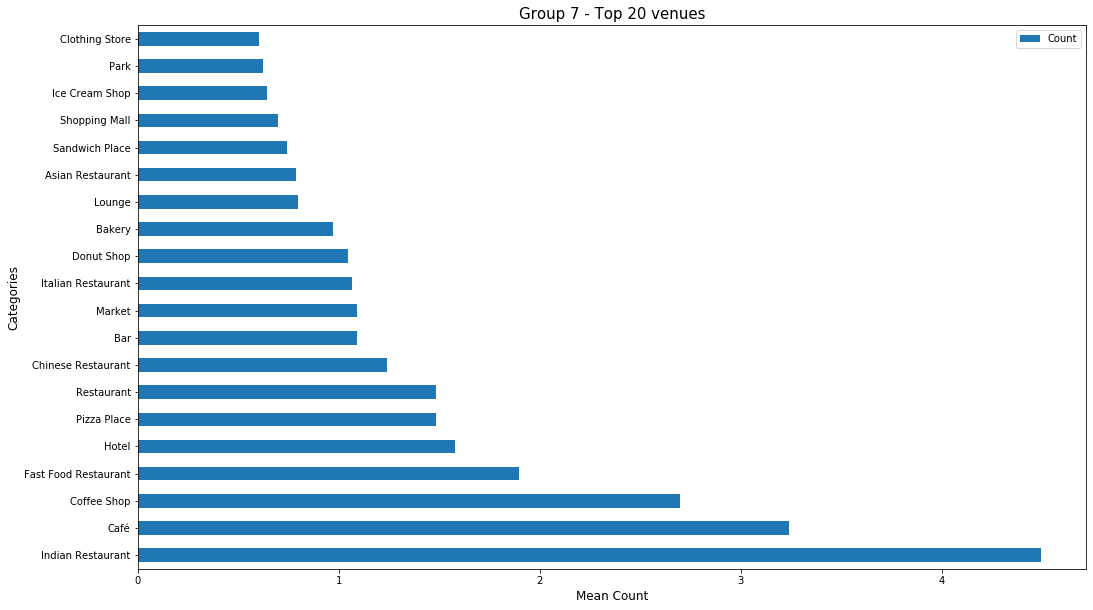

In [68]:
group7_venues.set_index('Category').head(20).plot(kind='barh', figsize=(17, 10))

plt.xlabel('Mean Count',size=12) 
plt.ylabel('Categories',size=12)
plt.title('Group 7 - Top 20 venues',size=15) 

plt.show()